In [1]:
%env RAYON_NUM_THREADS=4

env: RAYON_NUM_THREADS=4


In [2]:
import aesara
import aesara.tensor as at
import pymc as pm
import numpy as np
import nuts_py
import numba
from math import prod
import fastprogress
import arviz
import os
import threadpoolctl

/home/adr/mambaforge/envs/pymc-dev/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
# Some helper functions to compile logp functions as needed
def compute_shapes(model):
    point = pm.model.make_initial_point_fn(model=model, return_transformed=True)(0)

    value_vars = model.value_vars.copy()
    trace_vars = {
        name: var
        for (name, var) in model.named_vars.items()
        if var not in model.observed_RVs + model.potentials
    }

    shape_func = aesara.function(
        inputs=[],
        outputs=[var.shape for var in trace_vars.values()],
        givens=(
            [(obs, obs.tag.observations) for obs in model.observed_RVs]
            + [
                (trace_vars[name], point[name])
                for name in trace_vars.keys()
                if name in point
            ]
        ),
        mode=aesara.compile.mode.FAST_COMPILE,
        on_unused_input="ignore",
    )
    return {name: shape for name, shape in zip(trace_vars.keys(), shape_func())}


def make_functions(model):
    shapes = compute_shapes(model)

    # Make logp_dlogp_function
    joined = at.dvector("__joined_variables")

    value_vars = [model.rvs_to_values[var] for var in model.free_RVs]

    logp = model.logpt()
    grads = at.grad(logp, value_vars)
    grad = at.concatenate([grad.ravel() for grad in grads])

    count = 0
    joined_slices = []
    joined_shapes = []
    joined_names = []

    symbolic_sliced = []
    for var in model.free_RVs:
        value_var = model.rvs_to_values[var]

        joined_names.append(value_var.name)
        shape = shapes[value_var.name]
        joined_shapes.append(shape)
        length = prod(shape)
        slice_val = slice(count, count + length)
        joined_slices.append(slice_val)
        symbolic_sliced.append((value_var, joined[slice_val].reshape(shape)))
        count += length

    num_free_vars = count

    # We should avoid compiling the function, and optimize only
    func = aesara.function(
        (joined,), (logp, grad), givens=symbolic_sliced, mode=aesara.compile.NUMBA
    )
    fgraph = func.maker.fgraph
    func = aesara.link.numba.dispatch.numba_funcify(fgraph)
    # logp_func = numba.njit(func)
    logp_func = func

    # Make function that computes remaining variables for the trace
    trace_vars = {
        name: var
        for (name, var) in model.named_vars.items()
        if var not in model.observed_RVs + model.potentials
    }
    remaining_names = [name for name in trace_vars if name not in joined_names]
    remaining_rvs = [
        var for var in model.unobserved_value_vars if var.name not in joined_names
    ]

    all_names = joined_names + remaining_rvs

    all_names = joined_names.copy()
    all_slices = joined_slices.copy()
    all_shapes = joined_shapes.copy()

    for var in remaining_rvs:
        all_names.append(var.name)
        shape = shapes[var.name]
        all_shapes.append(shape)
        length = prod(shape)
        all_slices.append(slice(count, count + length))
        count += length

    allvars = at.concatenate([joined, *[var.ravel() for var in remaining_rvs]])
    func = aesara.function(
        (joined,), (allvars,), givens=symbolic_sliced, mode=aesara.compile.NUMBA
    )
    fgraph = func.maker.fgraph
    func = aesara.link.numba.dispatch.numba_funcify(fgraph)
    expanding_function = numba.njit(func, fastmath=True, error_model="numpy")

    return (
        num_free_vars,
        logp_func,
        expanding_function,
        (all_names, all_slices, all_shapes),
    )


def make_c_logp_func(N, logp_func):
    c_sig = numba.types.int64(
        numba.types.uint64,
        numba.types.CPointer(numba.types.double),
        numba.types.CPointer(numba.types.double),
        numba.types.CPointer(numba.types.double),
        numba.types.voidptr,
    )

    def rerun_inner(x):
        try:
            logp_func(x)
        except Exception as e:
            print(e)

    @numba.njit()
    def rerun(x):
        with numba.objmode():
            rerun_inner(x)

    def logp_numba(dim, x_, out_, logp_, user_data_):
        try:
            x = numba.carray(x_, (N,))
            out = numba.carray(out_, (N,))
            logp = numba.carray(logp_, ())

            logp_val, grad = logp_func(x)
            logp[()] = logp_val
            out[...] = grad

            if not np.all(np.isfinite(out)):
                return 2
            if not np.isfinite(logp_val):
                return 3
            return 0
        except Exception:
            return 1

    # logp_numba.compile()
    return logp_numba, c_sig


def sample(
    *,
    N,
    logp_numba,
    expanding_function,
    shape_info,
    n_tune,
    n_draws,
    n_chains,
    seed=42,
    max_treedepth=10,
    target_accept=0.8
):
    def make_user_data():
        return 0

    settings = nuts_py.lib.PySamplerArgs()
    settings.num_tune = n_tune
    settings.maxdepth = max_treedepth
    settings.target_accept = target_accept
    x = np.random.randn(N)
    sampler = nuts_py.lib.PyParallelSampler(
        logp_numba.address,
        make_user_data,
        N,
        x,
        settings,
        n_chains=n_chains,
        n_draws=n_draws,
        seed=seed,
        n_try_init=10,
    )

    try:
        n_expanded = len(expanding_function(x)[0])
        draws = np.full((n_chains, n_draws + n_tune, n_expanded), np.nan)
        infos = []
        for draw, info in fastprogress.progress_bar(
            sampler, total=n_chains * (n_draws + n_tune)
        ):
            infos.append(info)
            draws[info.chain, info.draw, :] = expanding_function(draw)[0]
    finally:
        sampler.finalize()

    trace_dict = {}
    trace_dict_tune = {}
    for name, slice_, shape in zip(*shape_info):
        trace_dict_tune[name] = draws[:, :n_tune, slice_].reshape(
            (n_chains, n_tune) + tuple(shape)
        )
        trace_dict[name] = draws[:, n_tune:, slice_].reshape(
            (n_chains, n_draws) + tuple(shape)
        )

    stat_dtypes = {
        "index_in_trajectory": np.int64,
        "mean_tree_accept": np.float64,
        "depth": np.int64,
        "maxdepth_reached": bool,
        "logp": np.float64,
        "energy": np.float64,
        "diverging": bool,
        "step_size": np.float64,
        "step_size_bar": np.float64,
        "mean_tree_accept": np.float64,
    }

    # This is actually relatively slow, we should be able to speed this up
    stats = {}
    stats_tune = {}
    for name, dtype in stat_dtypes.items():
        stats[name] = np.zeros((n_chains, n_draws), dtype=dtype)
        stats_tune[name] = np.zeros((n_chains, n_tune), dtype=dtype)

    for info in infos:
        info_dict = info.as_dict()
        if info.draw < n_tune:
            out = stats_tune
            draw = info.draw
        else:
            out = stats
            draw = info.draw - n_tune
        for name in stat_dtypes:
            out[name][info.chain, draw] = info_dict[name]

    return arviz.from_dict(
        posterior=trace_dict,
        warmup_posterior=trace_dict_tune,
        save_warmup=True,
        coords=model.coords,
        dims=model._RV_dims,
        sample_stats=stats,
        warmup_sample_stats=stats_tune,
    )

In [4]:
N = 1000
idx = np.arange(N, dtype=int)
np.random.shuffle(idx)
with pm.Model() as model:
    mu = pm.Normal("a", shape=N, sigma=1e-4)
    #b = pm.Normal("b", shape=N, sigma=2000.)
    #pm.Deterministic("b", 2 * a)
    #sd = pm.Gamma("sd", sigma=0.1, mu=1)
    #pm.Normal("a", sigma=1, shape=N)
    #pm.Gamma("b", mu=1, sigma=0.1, shape=N)
    #pm.SkewNormal("a", alpha=np.array([3., 3.]), shape=2)
    #pm.HalfNormal("a", shape=2)
    #pm.Mixture("a", w=[0.5, 0.5])
    #pm.Normal("y", observed=3.)
    pm.Normal("y", mu=mu[idx], observed=5 + np.random.randn(N))

In [5]:
n_chains = 4

## Sample using PyMC NUTS

In [6]:
%%time
with threadpoolctl.threadpool_limits(1):
    with model:
        trace_py = pm.sample(
            init="jitter+adapt_diag_grad",
            draws=1000,
            chains=n_chains,
            cores=10,
            idata_kwargs={"log_likelihood": False},
            compute_convergence_checks=False,
            target_accept=0.8,
            discard_tuned_samples=False,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


CPU times: user 5.48 s, sys: 607 ms, total: 6.08 s
Wall time: 19.2 s


## Compile functions for rust sampler

In [9]:
from aesara import config

In [10]:
config.numba__error_model = "numpy"
config.numba__nogil = True
config.numba__cache = False
config.numba__boundscheck = True
config.numba__fastmath = True
config.numba__parallel = False

In [11]:
kwargs = {
    "error_model": config.numba__error_model,
    "nogil": config.numba__nogil,
    "boundscheck": config.numba__boundscheck,
    "fastmath": config.numba__fastmath,
    "parallel": config.numba__parallel,
}

In [12]:
%%time
n_dim, logp_func, expanding_function, shape_info = make_functions(model)
logp_func = numba.njit(**kwargs)(logp_func)
logp_numba_raw, c_sig = make_c_logp_func(n_dim, logp_func)
logp_numba = numba.cfunc(c_sig, **kwargs)(logp_numba_raw)

CPU times: user 4.34 s, sys: 84.6 ms, total: 4.43 s
Wall time: 4.47 s


In [19]:
#x = np.random.randn(n_dim)

#from numba.pycc import CC

#cc = CC('logp_module')
#cc.target_cpu = "host"
#logp_func(np.random.randn(n_dim))
#cc.export("logp_grad", logp_func.signatures[0])(logp_func)
#cc.compile()

#func_orig = model.logp_dlogp_function()
#func_orig.set_extra_values({})
#%timeit func_orig._aesara_function(x)

In [13]:
n_draws = 1000
seed = 40

In [14]:
def make_user_data():
    return 0

settings = nuts_py.lib.PySamplerArgs()
settings.num_tune = 1000
settings.maxdepth = 10
settings.target_accept = 0.8

x = np.random.randn(n_dim)

## Sample using rust sampler with no parallelization

In [15]:
%%time
draws = []
tune = []
for i in range(n_chains):
    sampler = nuts_py.lib.PySampler(logp_numba.address, make_user_data, x, n_dim, settings, draws=n_draws + settings.num_tune, chain=0, seed=seed + i)
    samples = list(sampler)
    tune.extend(samples[:settings.num_tune])
    draws.extend(samples[settings.num_tune:])

CPU times: user 2.81 s, sys: 35.7 ms, total: 2.84 s
Wall time: 2.83 s


In [16]:
from scipy import stats
import seaborn as sns

In [17]:
#draws = np.array([vals for vals, _ in draws]).ravel()
#stats.ks_1samp(draws / 2, stats.norm.cdf)

## Rust sampling with raw parallelization

In [18]:
%%time
n_draws = 1000
seed = 4

def make_user_data():
    return 0

settings = nuts_py.lib.PySamplerArgs()
settings.num_tune = 1000
settings.maxdepth = 10
settings.target_accept = 0.8
x = np.random.randn(n_dim)

sampler = nuts_py.lib.PyParallelSampler(
    logp_numba.address,
    make_user_data,
    n_dim,
    x,
    settings,
    n_chains=n_chains,
    n_draws=n_draws,
    seed=seed,
    n_try_init=10
)
draws = list(sampler)

CPU times: user 5.36 s, sys: 101 ms, total: 5.47 s
Wall time: 1.3 s


## Parallel rust sampling with progress and arviz export

In [19]:
import os
os.getpid()

51389

In [20]:
%%time
for _ in range(1):
    with threadpoolctl.threadpool_limits(1):
        trace_rust = sample(
            N=n_dim,
            logp_numba=logp_numba,
            expanding_function=expanding_function,
            shape_info=shape_info,
            max_treedepth=10,
            n_tune=1000,
            n_draws=1000,
            n_chains=n_chains,
            seed=6,
            target_accept=0.8,
        )

CPU times: user 5.75 s, sys: 98.9 ms, total: 5.85 s
Wall time: 1.55 s


In [21]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

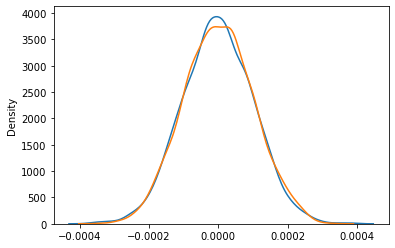

In [22]:
sns.kdeplot(trace_rust.posterior["a"].values[:, :, 0].ravel())
sns.kdeplot(trace_py.posterior["a"].values[:, :, 0].ravel())
#sns.kdeplot(np.random.randn(16_000))

In [23]:
#stats.ks_1samp(trace_rust.posterior["a"].values[:, :, 0].ravel() / 0.1, stats.norm.cdf)

In [24]:
#stats.ks_1samp(trace_py.posterior["a"].values[:, :, 0].ravel() / 0.1, stats.norm.cdf)

In [25]:
#sns.kdeplot(np.log(trace_rust.posterior["a"].values[:, :, -1].ravel()))
#sns.kdeplot(np.log(trace_py.posterior["a"].values[:, :, -1].ravel()))

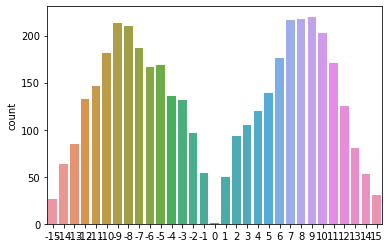

In [26]:
sns.countplot(x=trace_rust.sample_stats.index_in_trajectory.values.ravel());

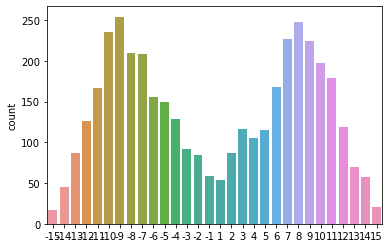

In [27]:
sns.countplot(x=trace_py.sample_stats.index_in_trajectory.values.ravel());

<AxesSubplot:title={'center':'x\n0'}>

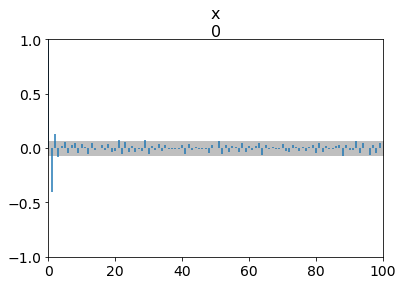

In [28]:
arviz.plot_autocorr(trace_rust.posterior.a.values[0, :, 0])

<AxesSubplot:title={'center':'x\n0'}>

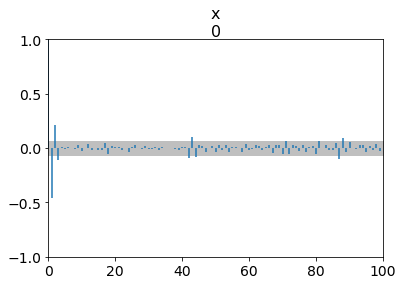

In [29]:
arviz.plot_autocorr(trace_py.posterior.a.values[0, :, 0])